## Sparse Coding Programming Assignment

_Robert McAnany_

_March 2, 2016_

This assignment explores sparse coding.  It is from Duke Professor Guillermo Sapiro's 2016 Coursera class _"Image and Video Processing from Mars to Hollywood with a Stop at the Hospital"_.  

Sparse coding represents image patches as a linear combination of a small number of basis elements.  In this assignment we attempt to denoise an image using this technique.  

Here is an illustration provided by Dr. Sapiro.  Sorry, I'm not going to explain it.  You can watch the lectures for yourself.  They are available in clips 65 through 72 on this YouTube playlist:  https://www.youtube.com/playlist?list=PLIUoqCcJd2BjZxdnlyQNnpnF4NmPn_jOy

<img src="sparse_coding.png">

Sparse coding is similar to JPEG, however there are a few differences.  

- **Basis elements.**  JPEG employs a 2D discrete cosine transform.  Sparse coding learns the basis elements from images.  In both cases, the combination of all basis elements is called a 'dictionary.'

- **Patches.**  JPEG patches are non-overlapping blocks in the image.  Sparse coding uses overlapping patches and determines the coded pixel value as an average of all overlapping patches.  An 8x8 patch size is common in both approaches.

- **Number of dictionary elements.**  JPEG uses a 'complete' dictionary, meaning it has 64 basis elements for an 8x8 patch size.  Sparse coding has no such requirement.  It is common to use an 'overcomplete' dictionary, meaning more than $n^2$ for an $n \times n$ patch size.

The assignment suggestions are given below.

> 1. Download and experiment with the sparse modeling free software packages linked in the class website.
2. Compare the results of sparse modeling image denoising with those of DCT-based image denoising as implemented in ipol.im
3. Consider an image and select K patches from it as the dictionary; select those patches at random. With this dictionary perform sparse modeling image denoising and compare with the results obtained when learning the dictionary.
4. Pick a particular example of sparse modeling image denoising and experiment with different dictionary sizes. Plot the histogram of atoms usage, meaning the number of times each atom is used considering all image patches.

In this project, we use the open source SPAMS (SPArse Modeling Software) library of Mairal, Bach, Ponce, Sapiro, Jenatton, and Obozinski.  Links below.
    
- **Publication** http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf
    
- **Website** http://spams-devel.gforge.inria.fr/

- **Python Documentation** http://spams-devel.gforge.inria.fr/doc-python/html/index.html

In [1]:
# Imports
from __future__ import division, print_function

import spams
import numpy as np
import time
from PIL import Image

from matplotlib import pyplot as plt
import time

from skimage import img_as_float
from skimage import io
from skimage.color import rgb2gray
from skimage.util import random_noise

from IPython.display import Image as ipImage

%matplotlib inline

# Plotting functions

def plot_1xc(imgs_list, titles_list, save_file=None):
    cols = len(imgs_list)
    i = 0
    
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,15))
    for c in range(cols):
        axes[c].imshow(imgs_list[i], cmap="gray", interpolation="nearest")
        axes[c].set_title(titles_list[i], size=20)
        axes[c].set_xticks([])
        axes[c].set_yticks([])
        i = i + 1
    plt.tight_layout();
    
    if not (save_file == None):
        filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
        fig.savefig(filename, bbox_inches='tight')
        
def plot_rxc(imgs_list, titles_list, ncol=3, save_file=None):
    cols = ncol
    rows = np.ceil(len(imgs_list)/cols).astype(int)
    if rows==1:
        plot_1xc(imgs_list, titles_list, save_file)
    else:
        i = 0
    
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15*rows/cols))
        for r in range(rows):
            for c in range(cols):
                if i < len(imgs_list):
                    axes[r,c].imshow(imgs_list[i], cmap="gray", interpolation="nearest")
                    axes[r,c].set_title(titles_list[i], size=20)
                    axes[r,c].set_xticks([])
                    axes[r,c].set_yticks([])
                i = i + 1
        plt.tight_layout();
    
        if not (save_file == None):
            filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
            fig.savefig(filename, bbox_inches='tight')

### Experiment with the SPAMS library

We start off with some sample code from the library website.  Here are two convenience functions used in the samples below.

In [2]:
def _objective(X,D,param,imgname = None):
    print ('Evaluating cost function...')
    lparam = _extract_lasso_param(param)
    alpha = spams.lasso(X,D = D,**lparam)
    # NB : as alpha is sparse, D*alpha is the dot product
    xd = X - D * alpha
    R = np.mean(0.5 * (xd * xd).sum(axis=0) + param['lambda1'] * np.abs(alpha).sum(axis=0))
    print ("objective function: %f" %R)
    #* display ?
    if imgname != None:
        img = spams.displayPatches(D)
        print ("IMG %s" %str(img.shape))
        x = np.uint8(img[:,:,0] * 255.)
        image = Image.fromarray(x,mode = 'L')
        # image.save("%s.png" %imgname)
        return image
    
def _extract_lasso_param(f_param):
    lst = [ 'L','lambda1','lambda2','mode','pos','ols','numThreads',
           'length_path','verbose','cholesky']
    l_param = {'return_reg_path' : False}
    for x in lst:
        if x in f_param:
            l_param[x] = f_param[x]
    return l_param

This sample code learns a dictionary from an image.

In [3]:
img = io.imread("../images/boat.png")

I = np.array(img) / 255.
if I.ndim == 3:
    A = np.asfortranarray(I.reshape((I.shape[0],
                                     I.shape[1] * I.shape[2])))
    rgb = True
else:
    A = np.asfortranarray(I)
    rgb = False

m = 8;n = 8;
X = spams.im2col_sliding(A,m,n,rgb)

X = X - np.tile(np.mean(X,0),(X.shape[0],1))

X = np.asfortranarray(X / np.tile(np.sqrt((X * X).sum(axis=0)),
                                  (X.shape[0],1)),dtype = np.float)

# learns a dictionary with 25 elements
param = { 'K' : 25, 'lambda1' : 0.15, 'numThreads' : 4, 
         'batchsize' : 400, 'iter' : 1000}

########## FIRST EXPERIMENT ###########
tic = time.time()
D = spams.trainDL(X,**param)
tac = time.time()
t = tac - tic
print ('time of computation for Dictionary Learning: %f' %t)

##param['approx'] = 0
# save dictionnary as dict.png
dict0_img = _objective(X,D,param,'dict')

time of computation for Dictionary Learning: 7.776210
Evaluating cost function...
objective function: 0.332737
IMG (46, 46, 1)


/home/robert/anaconda2/lib/python2.7/site-packages/spams.py:424: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if D == None:


The SPAMS software allows for 'warm restarts' for dictionary creation.  In this sample, a dictionary is created from scratch on one half the image patches.  It is updated on the other half.

In [4]:
run_this = True

if run_this:
    #### SECOND EXPERIMENT ####
    print ("*********** SECOND EXPERIMENT ***********")

    X1 = X[:,0:X.shape[1]/2]
    X2 = X[:,X.shape[1]/2 -1:]
    param['iter'] = 500
    tic = time.time()
    (D,model) = spams.trainDL(X1,return_model = True,
                              **param)
    tac = time.time()
    t = tac - tic
    print ('time of computation for Dictionary Learning: %f\n' %t)

    dict1_img = _objective(X,D,param,'dict1')

    # Then reuse the learned model to retrain a few iterations more.
    param2 = param.copy()
    param2['D'] = D
    tic = time.time()
    (D,model) = spams.trainDL(X2,return_model = True,
                              model = model,**param2)
    tac = time.time()
    t = tac - tic
    print ('time of computation for Dictionary Learning: %f' %t)
    dict2_img = _objective(X,D,param,'dict2')

*********** SECOND EXPERIMENT ***********
time of computation for Dictionary Learning: 4.031389

Evaluating cost function...
objective function: 0.334309

/home/robert/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/robert/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/robert/anaconda2/lib/python2.7/site-packages/spams.py:1783: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if D == None:



IMG (46, 46, 1)
time of computation for Dictionary Learning: 3.653739
Evaluating cost function...
objective function: 0.333283
IMG (46, 46, 1)


Here are the three dictionaries created above.

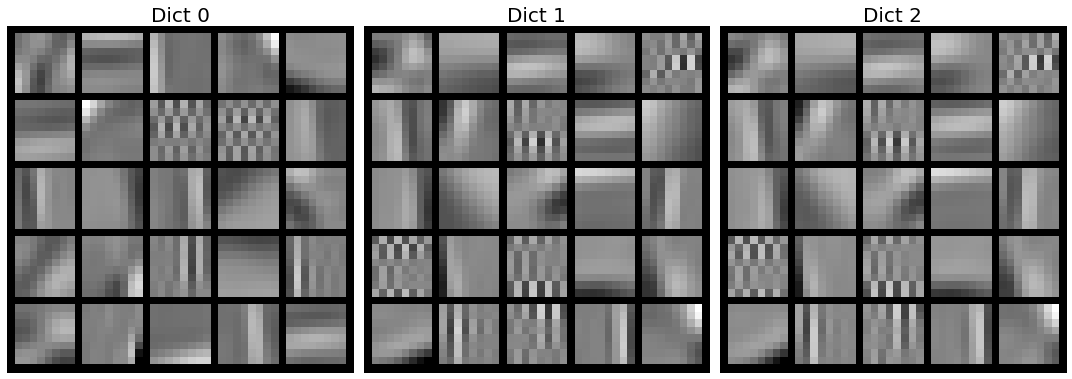

In [5]:
plot_rxc([dict0_img, dict1_img, dict2_img], ["Dict 0", "Dict 1", "Dict 2"])

### Patch Indexing

Before we get to image denoising, a short detour is needed.  We need a way to get all the overlapping patches of a given target pixel.  There is a slight complication.  For computational efficiency, the image patches are stored in an expanded matrix.  Patches need to be extracted from that matrix.  

Let's start with the more familiar layout -- patches on the image.  The sketch below shows the target pixel $p(i,j)$ and three of its overlapping patches.  Patch origins are in the upper left corner and denoted $O(x)$.

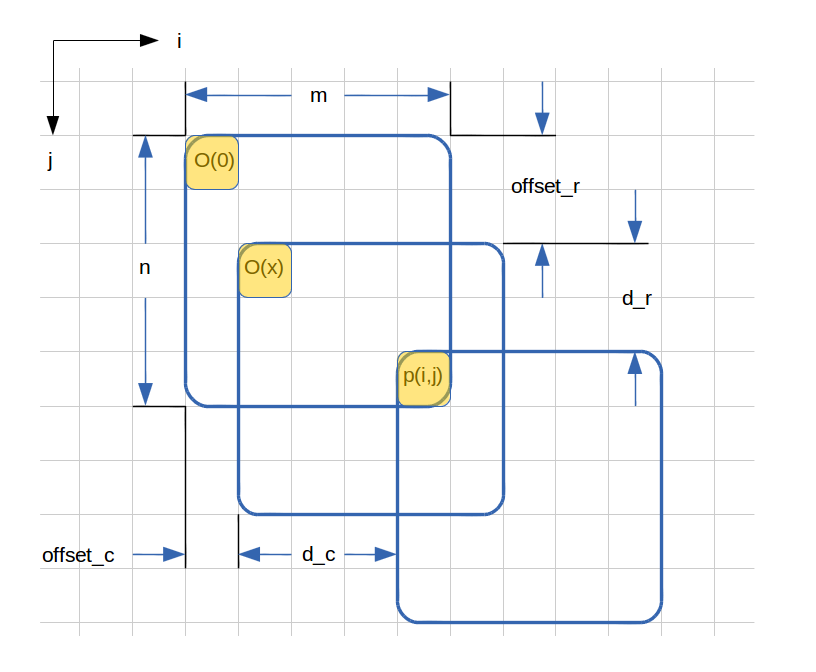

In [6]:
ipImage(filename='./patch_sketch.png', width=500) 

The location of the patch origin with respect to the whole image is

$$
\begin{aligned}
O(x) &= (ii,jj) \\
ii &= i - (m-1) + offset_c \\
&= i - m + offset_c + 1\\
jj &= j - (n-1) + offset_r \\
&= j - n + offset_r + 1 \\
\end{aligned}
$$

The location of the target pixel with respect to the patch origin is

$$
\begin{aligned}
i_{patch} &= d_c \\
&= m - offset_c - 1 \\
j_{patch} &= n - offset_r - 1 \\
\end{aligned}
$$

We can test this on some made up index numbers.

In [7]:
M = 5; N = 5; offset_c = 1; offset_r = 2; i = 10; j = 11
# ii should be 7, jj should be 9
# i_patch should be 3, j_patch should be 2
ii = i - M + offset_c + 1
jj = j - N + offset_r + 1
i_patch = M - offset_c - 1
j_patch = N - offset_r - 1
print(ii==7, jj==9, i_patch==3, j_patch==2)

True True True True


So far, so good.  Now let's see if we can find the patch with origin at (i,j) = (250,100) in our original image.  

We will extract the patch from the original image and try to extract the same patch from the expanded matrix.  If correct, subtracting one from the other should give an array of 64 zeros.

In [8]:
patch_as_col = np.zeros(m*n)
N = 0; i = 250; j = 100
X_test = spams.im2col_sliding(A,m,n,rgb)

for c in (j + np.arange(8)):
    for r in (i + np.arange(8)):
        patch_as_col[N] = I[r,c]
        N += 1
X_test_index = i + j*(512-n+1)
patch_as_col - X_test[:, X_test_index]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Now let's see if we can find the target pixel in all patches that are supposed to contain that pixel.

In [9]:
origin_pix = I[i,j]
all_match = True
for offset_r in range(n):
    for offset_c in range(m):
        target_pix = I[i+offset_c, j+offset_r]
        patch_pix = patch_as_col[offset_c + offset_r*n]
        if not (np.abs(target_pix - patch_pix) < 1e-6):
            print("Mismatch", offset_r, offset_c)
            all_match=False

print("All match:", all_match)

All match: True


That seems to be working.  

Now we need to go all the way.  That is, for every target pixel in the entire image, get the patch origins, get the patch columns, then extract the target pixel from the patch column.  

We define three functions that will be used later on for this task.

In [10]:
def get_patch_origin_indices(target_indices, offset_r, offset_c):
    return (target_indices[0]-offset_c, target_indices[1]-offset_r)

def get_patch_as_column(origin_indices, column_matrix, image_height, n):
    column_matrix_index = origin_indices[0] + origin_indices[1]*(image_height-n+1)
    return column_matrix[:, column_matrix_index]

def get_target_from_column(patch_column, offset_r, offset_c, n):
    return patch_column[offset_c + offset_r*n]

# Test with original image data in column-matrix format
miscount = 0
X_test = spams.im2col_sliding(A,m,n,rgb)

for r in range(n, I.shape[0]-n-1):
    for c in range(m, I.shape[1]-m-1):
        for offset_r in range(n):
            for offset_c in range(m):
                target_indices = (r,c)
                origin_indices = get_patch_origin_indices(target_indices, 
                                                          offset_r, offset_c)
                patch_column = get_patch_as_column(origin_indices, 
                                                   X_test, I.shape[1], n)
                target_from_patch = get_target_from_column(patch_column, 
                                                           offset_r, offset_c, n)
                if not (np.abs(I[target_indices] - target_from_patch) < 1e-6):
                    miscount +=1
print("Error count:", miscount)       

Error count: 0


Looks like we can find the target pixel in the expanded matrix.  Now on to denoising.

### Image denoising

To denoise an image, we learn a dictionary on 'clean' images, then encode the noisy image with that dictionary.  In practice, according to Professor Sapiro,

>_Normally you start with a generic dictionary trained on clean natural images, and then run a few iterations of KSVD on the given image (with very low sparsity, otherwise you learn the noise). small (undercomplete) dictionary will not work well for denoising, you need 10x or so times the size of the patch.
Also make sure you use overlapping patches._

The 'clean' source images were obtained from Wikimedia.  They are all larger that the noisy image.  The following function extracts a portion at random from a randomly selected source image.

In [11]:
def get_random_patch(im_collection, size=512):
    r = np.random.randint(len(im_collection))
    img = im_collection[r]
    img = img_as_float(rgb2gray(img))
    
    if (img.shape[0]==size) & (img.shape[1]==size):
        patch = img
    else:
        x_offset_max = img.shape[0] - size
        y_offset_max = img.shape[1] - size
        x_offset = np.random.randint(x_offset_max)
        y_offset = np.random.randint(y_offset_max)
        patch = img[x_offset:(x_offset+size), y_offset:(y_offset+size)]
        
    flip = np.random.rand()
    if flip > 0.5:
        patch = patch[:, ::-1]

    return patch

This following function builds the dictionary.  Note, it can do a 'cold start' or a 'warm start' depending on whether a pre-existing dictionary is supplied.

In [12]:
def construct_dictionary(im_collection, img_size, dict_size, D = None, iters=10):
    m = 8; n = 8; rgb = False
    
    for i in range(iters):    
        if not i % 50:
            print(str(i) + "/" + str(iters))
        I = get_random_patch(im_collection, size=img_size)
        A = np.asfortranarray(I)
        X = spams.im2col_sliding(A,m,n,rgb)
        X = np.asfortranarray(X)

        param = { 'K' : dict_size, 'lambda1' : 0.15, 'numThreads' : 4, 
                 'batchsize' : 400, 'iter' : 10}

        if D == None:
            D = spams.trainDL(X, **param)
        else:
            D = spams.trainDL(X, D=D, **param)

    return D

This code does the image reconstruction.  It is sloooow.  

In [13]:
def reconstruct_image(I_noisy, D, num_features):
    rgb = False
    m = 8;n = 8;

    A = np.asfortranarray(I_noisy)
    X = spams.im2col_sliding(A,m,n,rgb)

    X = np.asfortranarray(X)

    # Get our alphas for each patch
    alphas = spams.omp(X, D, L=num_features)
    D_alphas = D * alphas

    I_new = np.zeros_like(I_noisy)

    for r in range(n, I.shape[0]-n-1):
        for c in range(m, I.shape[1]-m-1):
            contributing_pixels = np.zeros(m*n)
            pix_num = 0
            for offset_r in range(n):
                for offset_c in range(m):                
                    target_indices = (r,c)
                    origin_indices = get_patch_origin_indices(target_indices, 
                                                              offset_r, offset_c)
                    patch_column = get_patch_as_column(origin_indices, 
                                                       D_alphas, I.shape[1], n)
                    target_from_patch = get_target_from_column(patch_column, 
                                                               offset_r, offset_c, n)
                    contributing_pixels[pix_num] = target_from_patch
                    pix_num += 1
            I_new[r,c] = np.mean(contributing_pixels)
    
    return(I_new)

This code loads the original image file and creates a noisy version of it.  The code also loads the 'clean' source images.  The original image and a few random portions of the source images are shown below.

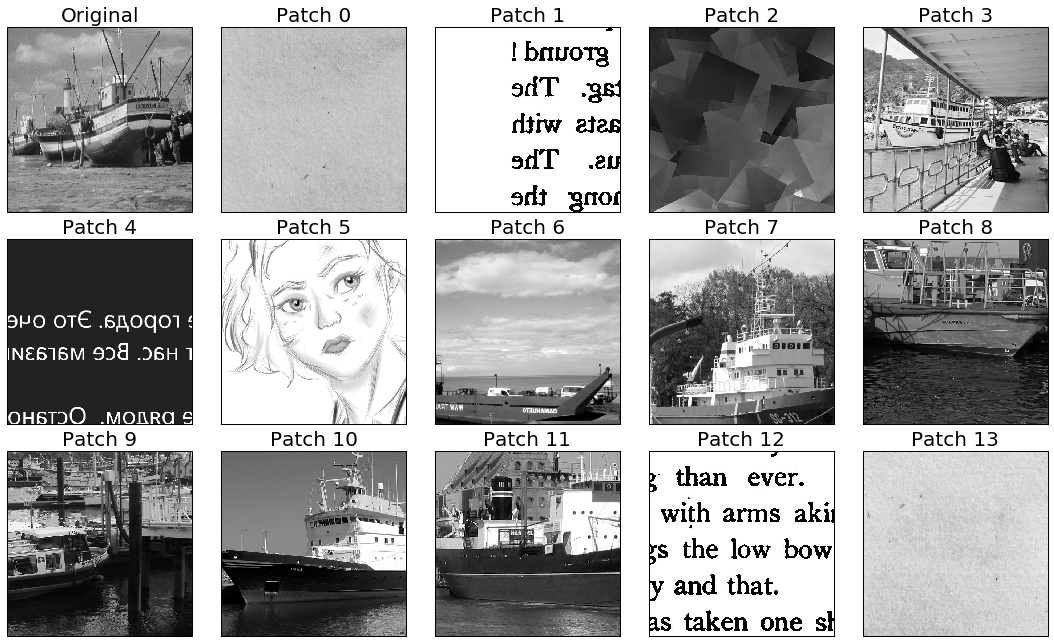

In [14]:
img_file = '../images/boat.png'
img = Image.open(img_file)
I = np.array(img) / 255.
I_noisy = random_noise(I, mode='gaussian', var=0.005)

# im_collection = io.imread_collection("../images/ships/*.jpg")
im_collection = io.imread_collection("../images/sparse_coding_source_images/*.jpg")

ims = []
titles = []
ims.append(img)
titles.append("Original")

for i in range(14):
    ims.append(get_random_patch(im_collection))
    titles.append("Patch " + str(i))
    
plot_rxc(ims, titles, ncol=5)

It is finally time to create the dictionary.  As noted above, the dictionary is created from the source images, then refined with a few iterations on the noisy image.  This takes about half an hour on my 2011-vintage laptop.

In [15]:
dict_size = 500
iters1 = 200
D = construct_dictionary(im_collection, I.shape[0], dict_size=dict_size, iters=iters1)

iters2 = 5
im_collection2 = io.imread_collection("../images/bo*.png")
D = construct_dictionary(im_collection2, I.shape[0], dict_size=dict_size, D=D, iters=iters2)

0/200
50/200
100/200
150/200
0/5


/home/robert/.local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


The last thing to do is reconstruct the noisy image.  We try a few values for the number of dictionary features to use in reconstruction.

In the captions below, 'L' is the dictionary size, 'k' is the number of dictionary features used, and 'iter' is the number of iterations.  There are two values for 'iter'.  The first is the number used on the source images, the second is that used on the noisy image.

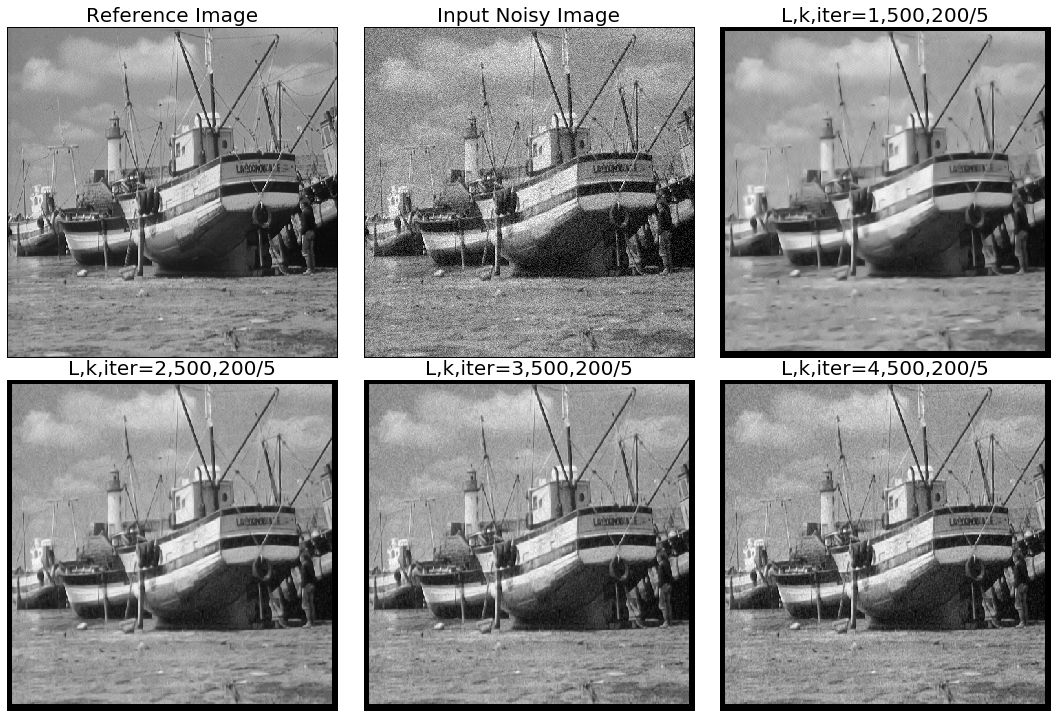

In [16]:
ims = []
ims.append(I)
ims.append(I_noisy)
titles = []
titles.append("Reference Image")
titles.append("Input Noisy Image")

for f in range(1,5):
    # print(f)
    I_reconstructed = reconstruct_image(I_noisy, D, num_features=f)

    ims.append(I_reconstructed.copy())
    s = "L,k,iter=" + str(f) + ","
    s = s + str(dict_size) + ","
    s = s + str(iters1) + "/" + str(iters2)
    titles.append(s)

plot_rxc(ims, titles, ncol=3)

### Conclusion

The image with two sparse coding elements turned out best in this example.  It is not as good as the original, but quite an improvement over the noisy version used in the test.

This exercise was mostly to introduce the concept of sparse coding, get a program to run, and to examine some results.  Obviously, much more experimentation is needed to make any definitive conclusions.  We would want to vary source and target images, noise levels, and parameter values, to name a few.  We would also want to compare results of this method with other techniques.  

### References

1. G. Sapiro.  Video and Image Processing from Mars to Hollywood with a Stop at the Hospital. Duke University via Coursera Jan-March 2016. Class.
1. J. Mairal, F. Bach, J. Ponce and G. Sapiro.  Online Learning for Matrix Factorization and Sparse Coding.  Journal of Machine Learning Research 11 (2010).
1. M. Elad and M. Aharon.  Image Denoising Via Sparse and Redundant Representations Over Learned Dictionaries.  IEEE TRANSACTIONS ON IMAGE PROCESSING, VOL. 15, NO. 12, DECEMBER 2006.
1. J. Mairal, F. Bach and J. Ponce. Sparse Modeling for Image and Vision Processing. Foundations and Trends in Computer Graphics and Vision. vol 8. number 2-3. pages 85--283. 2014